In [405]:
# imports

import pandas as pd
import numpy as np
import string
import re

# NLP

import os
import random
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import sklearn
from sklearn.model_selection import train_test_split
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

# RandomForest
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# OVA
from sklearn.multiclass import OneVsRestClassifier

# xgboost
import xgboost as xgb

%matplotlib inline

# spacy
import spacy

import re
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

!python3 -m spacy download xx_ent_wiki_sm

import xx_ent_wiki_sm
nlp = xx_ent_wiki_sm.load()

In [782]:
# read the data

data = pd.read_csv('test_data_v5.tsv', sep='\t')

In [605]:
data.Intention.unique()

array(['OTHER', 'PROBLEM DISCOVERY', 'INFORMATION GIVING',
       'FEATURE REQUEST', 'INFORMATION SEEKING'], dtype=object)

In [783]:
# keep important information

data = data[['Rating', 'Title','Review', 'Platform', 'Intention']]
data = data[data['Review'].notna()].reset_index(drop=True)

In [786]:
data = data.drop_duplicates()

## Data preprocessing

In [789]:
data.loc[:, 'title_p'] = data.Title.apply(lambda x: gensim.utils.simple_preprocess(x) if pd.notnull(x) else [])
data.loc[:, 'review_p'] = data.Review.apply(lambda x: gensim.utils.simple_preprocess(x) if pd.notnull(x) else [])
data.loc[:, 'sum_all'] = data['title_p'] + data['review_p']


In [790]:
# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

# edite

stop_words.remove('не')
stop_words.remove('нет')
stop_words.remove('никогда')
stop_words.remove('нельзя')
stop_words.append('приложение')
stop_words.append('этим')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Anastasiia.Serova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [791]:
# remove stopwords

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

In [792]:
# normalize forme

import pymorphy2
morph = pymorphy2.MorphAnalyzer()


def morf_lem(text):
    texts_out = []
    for i in text:
        w = morph.parse(i)[0].normal_form
        texts_out.append(w)
    return texts_out

In [793]:
# stemmer 

from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("russian") # Choose a language


def stemming(text):
    texts_out = []
    for i in text:
        texts_out.append(stemmer.stem(i))
    return texts_out
    

In [794]:
# keep 'не' 

def me_ne(text):
    n = 0
    i = 0
    text_add = []
    for i in text:
        while n < len(text)-1:
            if text[n] == 'не':
                text[n] = text[n]+text[n+1]
                text_add.append(text[n])
                n+=2
            else:
                text_add.append(text[n])
                n+=1
    return(text_add)

In [795]:
data.loc[:, 'sum_all_st'] = data.sum_all.apply(remove_stopwords)

In [796]:
data.loc[:, 'sum_all_st_l'] = data.sum_all_st.apply(morf_lem)

In [797]:
data.loc[:, 'sum_all_st_l_s'] = data.sum_all_st_l.apply(stemming)

In [798]:
data.loc[:, 'sum_all_st_l_s_ne'] = data.sum_all_st_l_s.apply(me_ne)

## Train LDA model

In [799]:
# keep right intention
right_intention = ['PROBLEM DISCOVERY', 'INFORMATION GIVING','FEATURE REQUEST', 'INFORMATION SEEKING']

data_ri = data.loc[data.Intention.isin(right_intention) == True].reset_index(drop=True)

In [865]:
# Create Dictionary
id2word = corpora.Dictionary(data.sum_all_st_l_s_ne)

# Create Corpus
texts = data.sum_all_st_l_s_ne

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [875]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=24, 
                                           alpha='auto',
                                           per_word_topics=True)

In [876]:
# Print the Keyword in the topics
lda_model.print_topics(num_topics=-1)

[(0,
  '0.114*"банк" + 0.073*"перевод" + 0.053*"друг" + 0.052*"карт" + 0.044*"эт" + 0.035*"счет" + 0.033*"приложен" + 0.030*"сбер" + 0.028*"клиент" + 0.028*"деньг"'),
 (1,
  '0.161*"пользова" + 0.129*"мобильн" + 0.121*"нормальн" + 0.090*"проблем" + 0.070*"никак" + 0.062*"банковск" + 0.059*"антивирус" + 0.058*"приложен" + 0.042*"давн" + 0.037*"ужасн"'),
 (2,
  '0.199*"карт" + 0.070*"плох" + 0.063*"баланс" + 0.042*"худ" + 0.041*"посмотрет" + 0.030*"показыва" + 0.030*"id" + 0.028*"зачислен" + 0.027*"обратн" + 0.027*"оповещен"'),
 (3,
  '0.513*"ве" + 0.085*"отз" + 0.051*"устраива" + 0.040*"рук" + 0.038*"списан" + 0.037*"загрузк" + 0.028*"два" + 0.023*"недава" + 0.018*"перв" + 0.017*"очередн"'),
 (4,
  '0.294*"хорош" + 0.208*"сам" + 0.061*"банк" + 0.057*"один" + 0.046*"меня" + 0.038*"котор" + 0.027*"полезн" + 0.024*"сильн" + 0.024*"приложен" + 0.024*"благодар"'),
 (5,
  '0.189*"обновлен" + 0.068*"последн" + 0.062*"верс" + 0.061*"неработа" + 0.038*"обнов" + 0.032*"исправ" + 0.031*"вылета" + 

In [874]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.257396  0.169303       1        1  7.991885
0      0.212497  0.044797       2        1  7.386867
8      0.062876 -0.176503       3        1  7.243858
6     -0.287381  0.142930       4        1  6.974372
11    -0.040857 -0.250627       5        1  6.973551
19     0.130474 -0.037642       6        1  6.694029
1      0.190801  0.176976       7        1  6.353398
18     0.158511  0.107861       8        1  5.628296
15     0.058016 -0.230547       9        1  5.504122
5     -0.231974  0.063437      10        1  4.908096
2      0.025326 -0.090484      11        1  4.617581
7      0.029941 -0.069051      12        1  4.029681
16    -0.241303  0.096181      13        1  3.900384
14     0.091178  0.156421      14        1  3.414542
3     -0.176991  0.033701      15        1  3.412999
4     -0.096815  0.018412      16        1  3.290463
12    -0.019515  0.008633      17        1  3.279915
17    -0.101673  0.104382      18        1  3.012066
13    -0.008236 -0.119584      19        1  2.876088
9     -0.012271 -0.148595      20        1  2.507806, topic_info=         Term         Freq        Total Category  logprob  loglift
185     удобн  7744.000000  7744.000000  Default  30.0000  30.0000
183      очен  7188.000000  7188.000000  Default  29.0000  29.0000
270        ве  4130.000000  4130.000000  Default  28.0000  28.0000
14   сбербанк  3460.000000  3460.000000  Default  27.0000  27.0000
80   приложен  4543.000000  4543.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
112   открыва    23.728457   492.370937  Topic20  -5.6382   0.6532
122  неработа    44.887133  1301.361826  Topic20  -5.0008   0.3187
86    возможн    24.392372  1705.613956  Topic20  -5.6106  -0.5616
78       кажд    14.116177  1131.992524  Topic20  -6.1576  -0.6987
138  пользова    13.515115  1534.604285  Topic20  -6.2011  -1.0465

[870 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
24       19  0.987096          and
624       2  0.966690      android
346       1  0.994586        apple
25       19  0.793190  application
343      11  0.918232     appstore
...     ...       ...          ...
181      17  0.002954           эт
181      18  0.049971           эт
127       2  0.993770         этот
127      15  0.003822         этот
578      10  0.980150          ясн

[1338 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 9, 7, 12, 20, 2, 19, 16, 6, 3, 8, 17, 15, 4, 5, 13, 18, 14, 10])

In [ ]:
# Show coherence per number of topics 

In [804]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [805]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ri.sum_all_st_l_s_ne, start=2, limit=40, step=6)

In [809]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        texts=data.sum_all_st_l_s_ne, start=2, limit=40, step=6)

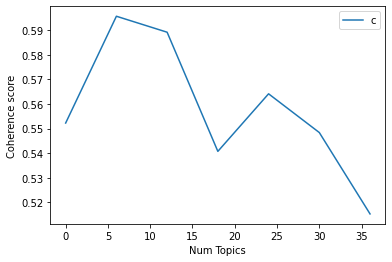

In [814]:
# Show graph
limit=40; start=0; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [815]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 0  has Coherence Value of 0.5522
Num Topics = 6  has Coherence Value of 0.5957
Num Topics = 12  has Coherence Value of 0.5892
Num Topics = 18  has Coherence Value of 0.5407
Num Topics = 24  has Coherence Value of 0.5641
Num Topics = 30  has Coherence Value of 0.5484
Num Topics = 36  has Coherence Value of 0.5153


## Analize results

In [731]:
def get_main_topic(text):
    list_topic = dict((y, x) for x, y in lda_model.get_document_topics(id2word.doc2bow(text)))
    value_s = sorted(list_topic)[-1]
    return list_topic[value_s]

In [732]:
def get_main_proba(text):
    list_topic = dict((y, x) for x, y in lda_model.get_document_topics(id2word.doc2bow(text)))
    value_s = sorted(list_topic)[-1]
    return value_s

In [877]:
data.loc[:, 'num_topic'] = data.sum_all_st_l_s.apply(get_main_topic)

In [838]:
data.loc[:, 'num_topic_proba'] = data.sum_all_st_l_s.apply(get_main_proba)

In [878]:
dict_res = {0: 'переводы',
            1: 'проблем нет',
            2: 'проблемы с балансом',
            3: 'все устраивает',
            4: 'все работает хорошо',
            5: 'проблемы с обновлением',
            6: 'рандомная проблема',
            7: 'оплаты',
            8: 'быстрая работа',
            9: 'кредит',
            10: 'платеж',
            11: 'уведомления',
            12: 'похвала, хорошая работа',
            13: 'вопрос по услугам',
            14: 'проблемы со входом',
            15: 'проблемы со входом',
            16: 'главный экран',
            17: 'удобное приложение',
            18: 'проблемы с интернетом',
            19: 'техподдержка',
            20: 'запрос фичи',
            21: 'оплаты офлайн', 
            22: 'понятная программа',
            23: 'шаблоны, долги',
            24: 'проблемы с шаблоном'}

In [879]:
data = data.replace({"num_topic": dict_res})

In [883]:
data_to_s = data[['Rating', 'Title', 'Review', 'Platform',
                  'Intention', 'num_topic' ]].rename(columns = {'num_topic' : 'Main_Topic'}).reset_index(drop=True)

In [886]:
data_to_s.to_csv('all_data_fin.csv')

In [ ]:
## teams data

In [ ]:
teams = pd.read_csv('teams.csv', sep=';')

In [ ]:
teams.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'bb', 'cc', 'dd',
                'ee', 'ff', 'gg', 'hh', 'ii', 'jj','kk', 'll', 'mm', 'nn', 'oo']

In [712]:
teams.loc[:, 'iOS_Release_Engineer'] = 'обновление'

In [713]:
teams.loc[2, 'iOS_Release_Engineer'] ='обновить'

In [714]:
teams.loc[3, 'iOS_Release_Engineer'] ='версия'

In [ ]:
def teams_key(column):
    teams.loc[8, column] = teams.loc[:, column].dropna().to_list()
    return teams.loc[8, column]
     
    

In [ ]:
def find_key(keys, row_s):
    a = [x for x in a if x in b]
        